# Covid-19_classification_Part2

### Research Objectives:
1. Develop neural network models leveraging a dataset of medical chest X-rays, categorised into three classes: Covid-19 cases, non-Covid chest infections (bacterial or viral pneumonia), and cases with no lung infection.

2. Investigate how different hyperparameters can affect a model’s performance.
### Data source :
[hosted on Kaggle](https://doi.org/10.34740/kaggle/dsv/3122958).

## Setup

This imports the required libraries and loads the data into training, validation, and testing datasets.

In [21]:
import tensorflow as tf

import os
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML, display

In [22]:
BATCH_SIZE = 64

IMAGE_SIZE = (150, 150, 1)
IMAGE_RESCALE = (IMAGE_SIZE[0], IMAGE_SIZE[1])

In [23]:
LABEL_VOCAB = ['COVID-19', 'Non-COVID', 'Normal']

# This "layer" will convert the directory name of the image into a one-hot label
label_encoder = tf.keras.layers.StringLookup(vocabulary=LABEL_VOCAB, num_oov_indices=0, output_mode='one_hot')

NUM_CLASSES = len(LABEL_VOCAB)

# Human-sensible labels for the classification

LABEL_TEXT = {i: l for i, l in enumerate(LABEL_VOCAB)}

In [24]:
# Where to find the data
base_dir = '/datasets/covid/'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Val')
test_dir = os.path.join(base_dir, 'Test')

In [25]:
def base_load_image(image_path, mask_image=False):
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    split_path = tf.strings.split(image_path, os.path.sep)
    label = split_path[-3]
    
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)
    
    if mask_image:    
        lung_mask_path = tf.strings.join([
            tf.strings.reduce_join(split_path[:-2], separator=os.path.sep),
            tf.constant(b'lung masks'),
            split_path[-1]],
            separator=os.path.sep)
        lung_mask = tf.io.read_file(lung_mask_path)
        lung_mask = tf.io.decode_png(lung_mask, channels=1)

        lung_mask /= 255
        lung_mask = tf.cast(lung_mask, tf.uint8)
        
        image = image * lung_mask
        image = tf.image.resize(image, IMAGE_RESCALE)
        image /= 255.0    
    
    else:
        image = tf.image.resize(image, IMAGE_RESCALE)
        image /= 255.0    
    
    # grab the label and encode it
    encoded_label = label_encoder(label)
    
    # return the image and the integer encoded label
    return (image, encoded_label)

def load_full_image(image_path):
    return base_load_image(image_path, mask_image=False)

def load_masked_image(image_path):
    return base_load_image(image_path, mask_image=True)

In [26]:
train_dataset_files = tf.data.Dataset.list_files(
    os.path.join(train_dir, '*', 'images', '*.png'))

train_data = train_dataset_files.map(load_full_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.shuffle(20000)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [27]:
validation_dataset_files = tf.data.Dataset.list_files(
    os.path.join(validation_dir, '*', 'images', '*.png'))

validation_data = validation_dataset_files.map(load_full_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.cache()
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [28]:
test_dataset_files = tf.data.Dataset.list_files(
    os.path.join(test_dir, '*', 'images', '*.png'))

test_data = test_dataset_files.map(load_full_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.cache()
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [29]:
len(train_data), len(validation_data), len(test_data)

(340, 85, 107)

In [30]:
def pretty_cm(cm):
    result_table  = '<h3>Confusion matrix</h3>\n'
    result_table += '<table border=1>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td><th colspan=10}>Predicted labels</th></tr>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td>'

    for _, cn in sorted(LABEL_TEXT.items()):
        result_table += f'<td><strong>{cn}</strong></td>'
    result_table += '</tr>\n'

    result_table += '<tr>\n'
    result_table += '<th rowspan=11>Actual labels</th>\n'

    for ai, an in LABEL_TEXT.items():
        result_table += '<tr>\n'
        result_table += f'  <td><strong>{an}</strong></td>\n'
        for pi, pn in sorted(LABEL_TEXT.items()):
            result_table += f'  <td>{cm[ai, pi]}</td>\n'
        result_table += '</tr>\n'
    result_table += "</table>"
    # print(result_table)
    display(HTML(result_table))

### Examining the data

In [11]:
sample_imgs, sample_labels = train_data.as_numpy_iterator().next()

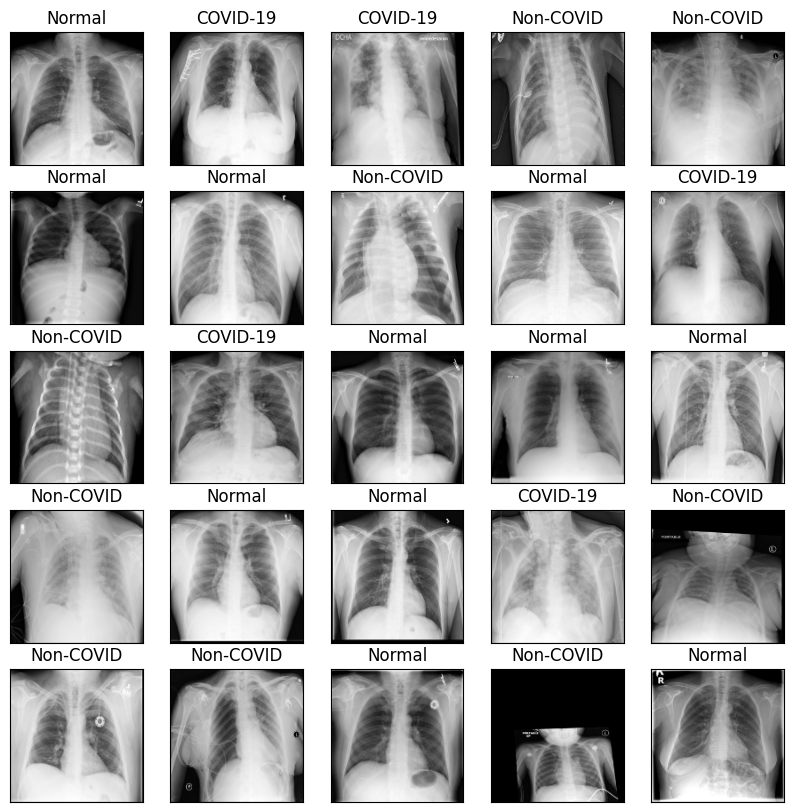

In [12]:
plt.figure(figsize=(10,10)) 
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(sample_imgs[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(LABEL_TEXT[np.argmax(sample_labels[i])])
plt.show()

## Validation and test labels    

Use these for generating confusion matrices.

In [31]:
validation_labels = np.array(list(validation_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_labels = np.argmax(validation_labels, axis=1)
validation_labels.shape

(5417,)

In [32]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)
test_labels.shape

(6788,)

# Part a 

Create a two layer model, of 1024 neurons feeding into a three output neurons. Note that the initial Flatten layer should have an `input_shape=IMAGE_SIZE` (that is, `(150, 150, 1)`) and the final layer should have `NUM_CLASSES` units.

The 1024-neuron layer should use `sigmoid` activation. The 3-neuron layer should use `softmax` activation.

```
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 flatten (Flatten)           (None, 22500)             0         
                                                                 
 dense (Dense)               (None, 1024)              23041024  
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
=================================================================
Total params: 23,044,099
Trainable params: 23,044,099
Non-trainable params: 0
_________________________________________________________________
```

Store the model is a variable called `model_a`.

Use the SGD optimiser, with its default parameters, and train this model for 40 epochs. Train using the `train_data` and `validation_data` 

In [17]:
# Use additional cells as needed.


#import
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils
from tensorflow.keras.layers import Flatten, Dense

# Create the model
model_a = Sequential([
    Flatten(input_shape=IMAGE_SIZE),
    Dense(1024, activation='sigmoid'),
    Dense(NUM_CLASSES, activation='softmax')
])

In [20]:
# Compile the model

#import categorical_crossentropy
from tensorflow.keras.losses import categorical_crossentropy

opt = optimizers.SGD()
model_a.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])


In [24]:
# Train the model
history_a = model_a.fit(train_data, epochs=40, validation_data=validation_data, verbose=0)


In [22]:
#save the model
model_a.save("q2_model_a.keras")

In [25]:
# Save the training history
with open('q2_history.json', 'w') as f:
    json.dump(history_a.history, f)

In [13]:
#load the model
model_a_loaded = tf.keras.models.load_model('q2_model_a.keras')
#load the history
with open('q2_history.json') as f:
    history_a_loaded = json.load(f)

In [14]:
#plot the training history



# Extract relevant information from the loaded history
acc = history_a_loaded['accuracy']
val_acc = history_a_loaded['val_accuracy']
loss = history_a_loaded['loss']
val_loss = history_a_loaded['val_loss']

In [28]:
# Assuming acc, val_acc, loss, and val_loss are lists containing metric values for each epoch

epochs = range(len(acc))

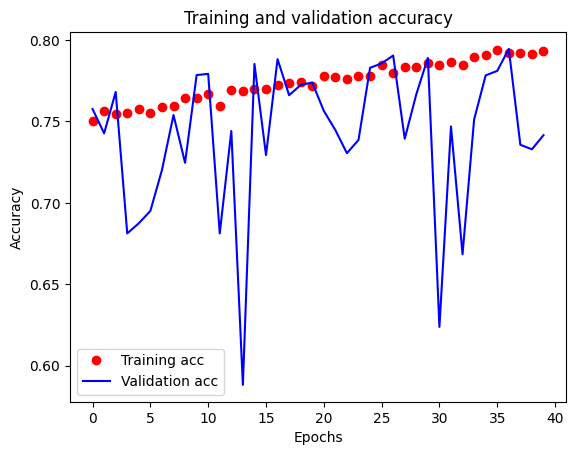

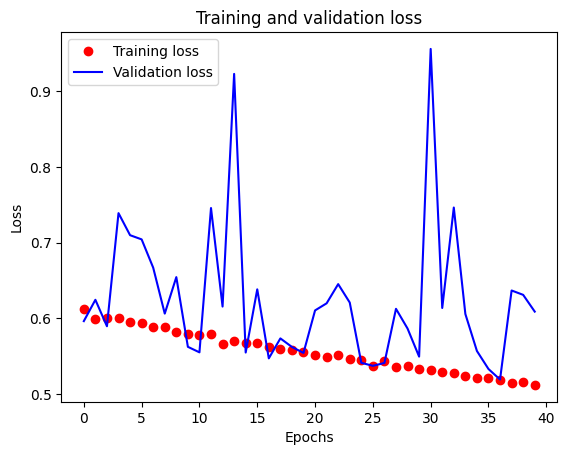

In [29]:
# Plotting accuracy
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Comment on the plots


The increasing training accuracy indicates that the model is learning the training data well. The fluctuating validation accuracy suggests that the model's performance on unseen data is inconsistent. It might not be generalising as effectively to new examples.

The decreasing training loss indicates that the model is fitting well to the training data.The fluctuating validation loss implies that the model's performance on the validation set is inconsistent. The model may be overly sensitive to variations in the validation data, which could be a sign of overfitting.

Therefore, While the model is learning the training data effectively, the inconsistent performance on the validation set indicates potential overfitting. The model might be too complex and capturing noise or specific patterns in the training data that don't generalise well.

In [30]:
# Evaluate the model on the test dataset
test_results = model_a.evaluate(test_data, verbose=0)

# Print the evaluation results
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]}")


Test Loss: 0.5360773801803589
Test Accuracy: 0.7781378626823425


### confusion matrix

In [16]:
#predict test data
test_predictions = model_a_loaded.predict(test_data)
test_predictions.shape

107/107 [==============================] - 0s 3ms/step


(6788, 3)

In [17]:
test_predictions[0]

array([0.41698042, 0.5663848 , 0.01663482], dtype=float32)

In [18]:
# take the max of probability
predict_labels = np.argmax(test_predictions, axis=1)

#check the first instance
predict_labels[0]

1

In [19]:
# Convert the actual labels to one-dimensional indices using argmax

actual_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels = np.argmax(actual_labels, axis=1)
actual_labels.shape

(6788,)

In [20]:
cm = tf.math.confusion_matrix(actual_labels, predict_labels).numpy()
pretty_cm(cm)

### comment on the Confusion matrix

Looking at the recall of each label, there are approximately 64%, 88%, and 76% for COVID-19, Non-COVID, and Normal, respectively. 

The recall values provide insights into the model's performance for each class. The model demonstrates a high confidence in identifying Non-COVID cases, achieving an impressive recall of 88%. However, it appears to face challenges in accurately predicting COVID-19 cases, as reflected in a lower recall of approximately 64%. This indicates that the model may find distinguishing COVID-19 instances more challenging compared to Non-COVID cases.

# Part b 

Using the model created in part (a) as a base, create a new model but with additional `Dense` layer, of 128 neurons, between the two existing `Dense` layers. 

The first two `Dense` layers should use the `sigmoid` activation function.

Store the model is a variable called `model_b`.

Use the SGD optimizer for training, with a learning rate of 0.005. Train the model for 60 epochs.


In [13]:
# Use additional cells as needed.


#import
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils
from tensorflow.keras.layers import Flatten, Dense



# Create model_b
model_b = Sequential([
    Flatten(input_shape=IMAGE_SIZE),
    Dense(1024, activation='sigmoid'),
    Dense(128, activation='sigmoid'),  # Additional Dense layer with 128 neurons
    Dense(NUM_CLASSES, activation='softmax')
])

In [14]:
#import categorical_crossentropy
from tensorflow.keras.losses import categorical_crossentropy

# Compile model_b with SGD optimizer and a learning rate of 0.005
opt_b = optimizers.SGD(learning_rate=0.005)
model_b.compile(optimizer=opt_b, loss=categorical_crossentropy, metrics=['accuracy'])


In [15]:
# Train model_b for 60 epochs
history_b = model_b.fit(train_data, epochs=60, validation_data=validation_data, verbose=0)

In [16]:
#save the model
model_b.save("q2_model_b.keras")

# Save the training history
with open('q2_history_b.json', 'w') as f:
    json.dump(history_b.history, f)

    

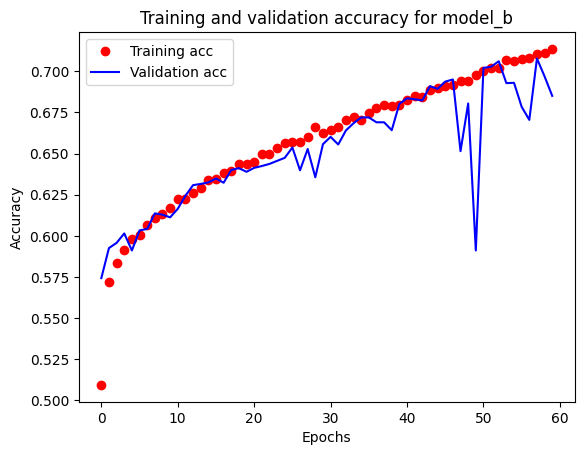

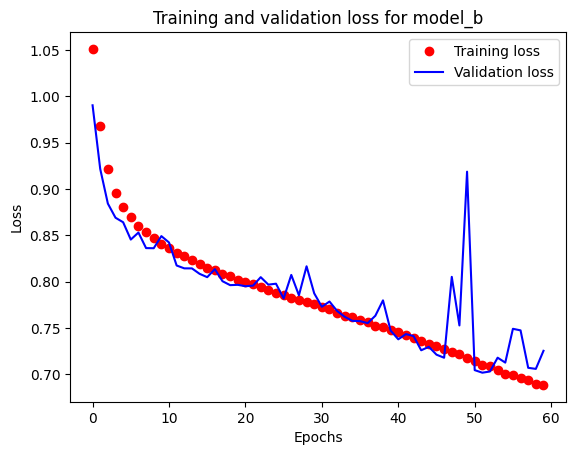

In [17]:
# Plotting accuracy for model_b
plt.plot(range(len(history_b.history['accuracy'])), history_b.history['accuracy'], 'ro', label='Training acc')
plt.plot(range(len(history_b.history['val_accuracy'])), history_b.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy for model_b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss for model_b
plt.plot(range(len(history_b.history['loss'])), history_b.history['loss'], 'ro', label='Training loss')
plt.plot(range(len(history_b.history['val_loss'])), history_b.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss for model_b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Comment

The model is effectively learning from the training data, evident from the increasing accuracy and decreasing loss.
Fluctuations in both validation accuracy and validation loss suggest the presence of some noise or variability in the data.
The model appears to generalise reasonably well to the validation set, as indicated by the alignment of validation metrics with training metrics.

In [18]:
# Evaluate model_b on the test dataset
test_results_b = model_b.evaluate(test_data, verbose=0)

# Print the evaluation results
print(f"Test Loss for model_b: {test_results_b[0]}")
print(f"Test Accuracy for model_b: {test_results_b[1]}")

Test Loss for model_b: 0.6778881549835205
Test Accuracy for model_b: 0.7093400359153748


### confusion matrix

In [21]:
# Generate confusion matrix for model_b
test_predictions_b = model_b.predict(test_data)
test_predictions_b.shape

107/107 [==============================] - 0s 3ms/step


(6788, 3)

In [22]:
# take the max of probability
predict_labels_b = np.argmax(test_predictions_b, axis=1)

#check the first instance
predict_labels_b[0]

2

In [23]:
# Convert the actual labels to one-dimensional indices using argmax

actual_labels2 = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
actual_labels2 = np.argmax(actual_labels2, axis=1)
actual_labels2.shape

(6788,)

In [24]:
cm = tf.math.confusion_matrix(actual_labels2, predict_labels_b).numpy()
pretty_cm(cm)

### comment on the Confusion matrix

Looking at the recall of each label, there are approximately 87%, 54%, and 71% for COVID-19, Non-COVID, and Normal, respectively.

The model exhibits a strong ability to correctly identify COVID-19 cases, achieving a high recall of 87%. However, it faces challenges in accurately predicting Non-COVID instances, reflected in a lower recall of approximately 54%. This suggests that the model may find distinguishing Non-COVID cases more challenging compared to COVID-19 cases. The recall for Normal cases stands at 71%, indicating a moderate level of accuracy in identifying this class. Overall, the model's performance varies across different classes, with notable strengths in detecting COVID-19 cases but potential areas for improvement in recognizing Non-COVID instances.

# Part c 

Evaluate the two models on all three of the training, validation, and test datasets. 

Compare and comment on the performance of the two models. 

Compare and comment on the two confusion matrices created above. 

In [16]:
# Use additional cells as needed.
model_a_loaded = tf.keras.models.load_model('q2_model_a.keras')
model_b_loaded = tf.keras.models.load_model('q2_model_b.keras')


# Evaluate model A
train_results_a = model_a_loaded.evaluate(train_data, verbose=0)
validation_results_a = model_a_loaded.evaluate(validation_data, verbose=0)
test_results_a = model_a_loaded.evaluate(test_data, verbose=0)

# Evaluate model B
train_results_b = model_b_loaded.evaluate(train_data, verbose=0)
validation_results_b = model_b_loaded.evaluate(validation_data, verbose=0)
test_results_b = model_b_loaded.evaluate(test_data, verbose=0)



In [17]:
print("Model A Performance:")
print(f"Train Loss: {train_results_a[0]}, Train Accuracy: {train_results_a[1]}")
print(f"Validation Loss: {validation_results_a[0]}, Validation Accuracy: {validation_results_a[1]}")
print(f"Test Loss: {test_results_a[0]}, Test Accuracy: {test_results_a[1]}")

print("\nModel B Performance:")
print(f"Train Loss: {train_results_b[0]}, Train Accuracy: {train_results_b[1]}")
print(f"Validation Loss: {validation_results_b[0]}, Validation Accuracy: {validation_results_b[1]}")
print(f"Test Loss: {test_results_b[0]}, Test Accuracy: {test_results_b[1]}")


Model A Performance:
Train Loss: 0.6217067837715149, Train Accuracy: 0.7433110475540161
Validation Loss: 0.6182671189308167, Validation Accuracy: 0.7463540434837341
Test Loss: 0.5910633206367493, Test Accuracy: 0.7575132846832275

Model B Performance:
Train Loss: 0.7195740938186646, Train Accuracy: 0.6906285881996155
Validation Loss: 0.7252136468887329, Validation Accuracy: 0.685065507888794
Test Loss: 0.6778882145881653, Test Accuracy: 0.7093400359153748


### Comparison and comment

Model A consistently outperforms Model B across all datasets, with higher training accuracy (74.3% vs. 69.1%), validation accuracy (74.6% vs. 68.5%), and test accuracy (75.8% vs. 70.9%). Model A also exhibits lower losses during training and validation, indicating superior convergence and fitting to the training data.

Analyzing the confusion matrices provides additional insights. Model A demonstrates recall rates of approximately 64%, 88%, and 76% for COVID-19, Non-COVID, and Normal, respectively. The model excels in identifying Non-COVID cases (88% recall) but faces challenges in accurately predicting COVID-19 cases (64% recall).

In contrast, Model B shows recall rates of approximately 87%, 54%, and 71% for COVID-19, Non-COVID, and Normal, respectively. It excels in correctly identifying COVID-19 cases (87% recall) but struggles with Non-COVID cases, reflected in a lower recall of approximately 54%.

Overall, Model A demonstrates a more balanced and reliable performance across different classes, while Model B exhibits strengths in detecting COVID-19 cases but faces challenges in recognizing Non-COVID instances.

# Masked images

The reson for the complicated image-loading function above is that this dataset has additional information for each X-ray image. As well as the actual image, there is a _mask_ image that identifies just the lungs in the X-ray. The `load_masked_image` function uses this mask data to return an image that comprises just the lungs in the X-ray.


In [33]:
val_image_name = validation_dataset_files.as_numpy_iterator().next().decode('utf-8')
val_image_name

'/datasets/covid/Val/COVID-19/images/sub-S09671_ses-E26823_run-1_bp-chest_vp-ap_dx.png'

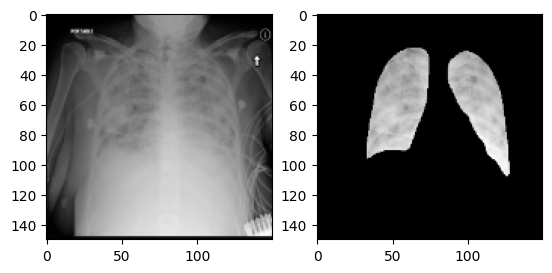

In [14]:
plt.subplot(1, 2, 1)
plt.imshow(load_full_image(val_image_name)[0].numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(load_masked_image(val_image_name)[0].numpy(), cmap='gray')
plt.show()

Alternative versions of the TensorFlow datasets that utilize these masked images can be loaded, followed by training and evaluating models using them.

In [34]:
train_masked_data = train_dataset_files.map(load_masked_image, num_parallel_calls=tf.data.AUTOTUNE)
train_masked_data = train_masked_data.cache()
train_masked_data = train_masked_data.shuffle(20000)
train_masked_data = train_masked_data.batch(BATCH_SIZE)
train_masked_data = train_masked_data.prefetch(tf.data.AUTOTUNE)

In [35]:
validation_masked_data = validation_dataset_files.map(load_masked_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_masked_data = validation_masked_data.cache()
validation_masked_data = validation_masked_data.batch(BATCH_SIZE)
validation_masked_data = validation_masked_data.prefetch(tf.data.AUTOTUNE)

In [36]:
test_masked_data = test_dataset_files.map(load_masked_image, num_parallel_calls=tf.data.AUTOTUNE)
test_masked_data = test_masked_data.cache()
test_masked_data = test_masked_data.batch(BATCH_SIZE)
test_masked_data = test_masked_data.prefetch(tf.data.AUTOTUNE)

Load the labels for the masked datasets.

In [37]:
validation_masked_labels = np.array(list(validation_masked_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_masked_labels = np.argmax(validation_masked_labels, axis=1)
validation_masked_labels.shape

(5417,)

In [38]:
test_masked_labels = np.array(list(test_masked_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_masked_labels = np.argmax(test_masked_labels, axis=1)
test_masked_labels.shape

(6788,)

# Part d 

## Part (i)

Evaluate `model_b`using the masked X-ray images.

In [21]:
# Load the model if not already loaded
model_b_loaded = tf.keras.models.load_model('q2_model_b.keras')

In [22]:
# Evaluate the model on the masked test dataset
test_masked_results = model_b_loaded.evaluate(test_masked_data, verbose=0)

# Print the evaluation results
print(f"Test Masked Loss: {test_masked_results[0]}")
print(f"Test Masked Accuracy: {test_masked_results[1]}")

Test Masked Loss: 1.790724754333496
Test Masked Accuracy: 0.365350604057312


The evaluation results on the masked test dataset for model_b show a test masked accuracy of approximately 36.5% and a test masked loss of around 1.79.

This indicates that the model's performance decreases when using the lung-masked X-ray images compared to the original images. The accuracy is significantly lower, suggesting that the model may struggle to make accurate predictions when presented with images focused only on the lungs. The higher loss also implies that the model's predictions on the masked X-ray images are less accurate or less aligned with the true labels compared to its predictions on the original, unmasked X-ray images.

## Part (ii)

Create another model, called `model_d`, with an identical structure to `model_b`. Train `model_d` on the masked dataset, using the same training hyperparameters that you used in part (b). Evaluate `model_d` on both the masked and unmasked datasets.

In [24]:

#import
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils
from tensorflow.keras.layers import Flatten, Dense


# Create model_d with an identical structure to model_b
model_d = Sequential([
    Flatten(input_shape=IMAGE_SIZE),
    Dense(1024, activation='sigmoid'),
    Dense(128, activation='sigmoid'),  # Dense layer with 128 neurons
    Dense(NUM_CLASSES, activation='softmax')
])

In [26]:
#import categorical_crossentropy
from tensorflow.keras.losses import categorical_crossentropy
# Compile model_d
opt_d = optimizers.SGD(learning_rate=0.005)
model_d.compile(optimizer=opt_d, loss=categorical_crossentropy, metrics=['accuracy'])

In [27]:
# Train model_d on the masked dataset
history_d_masked = model_d.fit(train_masked_data, epochs=60, validation_data=validation_masked_data, verbose=0)

In [30]:
# Save the model
model_d.save("model_d.keras")
# Save the training history
with open('q2_history_d.json', 'w') as f:
    json.dump(history_d_masked.history, f)

In [40]:
# Load the model if not already loaded
model_d = tf.keras.models.load_model('model_d.keras')

In [41]:
# Evaluate Model D on the masked train dataset
train_masked_results_d = model_d.evaluate(train_masked_data, verbose=0)

# Evaluate Model D on the masked validation dataset
validation_masked_results_d = model_d.evaluate(validation_masked_data, verbose=0)

# Evaluate Model D on the masked test dataset
test_masked_results_d = model_d.evaluate(test_masked_data, verbose=0)

# Evaluate Model D on the unmasked train dataset
train_unmasked_results_d = model_d.evaluate(train_data, verbose=0)

# Evaluate Model D on the unmasked validation dataset
validation_unmasked_results_d = model_d.evaluate(validation_data, verbose=0)

# Evaluate Model D on the unmasked test dataset
test_unmasked_results_d = model_d.evaluate(test_data, verbose=0)

In [42]:
# Print the evaluation results
print("Model D Performance on Masked Datasets:")
print(f"Masked Train Loss: {train_masked_results_d[0]}, Masked Train Accuracy: {train_masked_results_d[1]}")
print(f"Masked Validation Loss: {validation_masked_results_d[0]}, Masked Validation Accuracy: {validation_masked_results_d[1]}")
print(f"Masked Test Loss: {test_masked_results_d[0]}, Masked Test Accuracy: {test_masked_results_d[1]}")

print("\nModel D Performance on Unmasked Datasets:")
print(f"Unmasked Train Loss: {train_unmasked_results_d[0]}, Unmasked Train Accuracy: {train_unmasked_results_d[1]}")
print(f"Unmasked Validation Loss: {validation_unmasked_results_d[0]}, Unmasked Validation Accuracy: {validation_unmasked_results_d[1]}")
print(f"Unmasked Test Loss: {test_unmasked_results_d[0]}, Unmasked Test Accuracy: {test_unmasked_results_d[1]}")

Model D Performance on Masked Datasets:
Masked Train Loss: 0.8813974857330322, Masked Train Accuracy: 0.5983881950378418
Masked Validation Loss: 0.8952375650405884, Masked Validation Accuracy: 0.5818718671798706
Masked Test Loss: 0.8974930644035339, Masked Test Accuracy: 0.5911903381347656

Model D Performance on Unmasked Datasets:
Unmasked Train Loss: 3.4693310260772705, Unmasked Train Accuracy: 0.3528897166252136
Unmasked Validation Loss: 3.478166341781616, Unmasked Validation Accuracy: 0.3522244691848755
Unmasked Test Loss: 3.452589750289917, Unmasked Test Accuracy: 0.35312315821647644


#### Comment on how model_d performs on these datasets

Model D exhibits notably superior performance when evaluated on masked datasets compared to unmasked datasets. These findings suggest that Model D, specialised in recognizing patterns within lung-focused X-ray images, struggles to generalise effectively to the broader context of complete X-ray images. The significant drop in accuracy and increase in loss on unmasked datasets indicate limitations in the model's ability to transfer learned patterns to diverse input data types, particularly those encompassing the entire chest area.

## Part (iii)

Compare the performance of `model_d` on the masked data to the performance of `model_b` on the unmasked data. Comment on the comparison. Suggest why the performance is different.

Comment:
Model D, trained on masked X-ray images, achieves a masked test accuracy of 0.591 and a masked test loss of 0.897. In contrast, Model B, trained on complete X-ray images, performs better with a higher unmasked test accuracy of 0.709 and a lower unmasked test loss of 0.678. This indicates that Model B, exposed to the entire chest area, performs superiorly on a broader range of unmasked test data compared to Model D, which focuses solely on the lungs in the X-ray.
The performance gap can be explained by Model D's specialisation in recognising patterns related to lung conditions during training on lung-focused X-ray images. Since masked images only show the lungs, Model D might struggle to generalise effectively to the complexity of unmasked X-ray data, which includes the entire chest area. Additionally, the process of masking might cause information loss, impacting the model's ability to recognise certain patterns present in unmasked images.

# Part e

Investigate the effect of changing the topology and other hyperparameters of the model.

Train **two** other models, based on the model in part (d). Train these models on the masked image datasets.

* One model has a different structure but use the same hyperparameters for training. 
* The other has the same structure as in part (d) but use different hyperparameters for training. 


In [43]:
# Create Model E with a different structure
model_e = Sequential([
    Flatten(input_shape=IMAGE_SIZE),
    Dense(512, activation='sigmoid'),  # Different number of neurons
    Dense(64, activation='sigmoid'),   # Different number of neurons
    Dense(NUM_CLASSES, activation='softmax')
])

# Use the same hyperparameters as in part (d)
opt = optimizers.SGD(learning_rate=0.005)
model_e.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model E on the masked dataset
history_e = model_e.fit(train_masked_data, epochs=60, validation_data=validation_masked_data, verbose=0)

# Save the model
model_e.save("model_e.keras")
# Save the training history
with open('q2_history_e.json', 'w') as f:
    json.dump(history_e.history, f)

In [46]:
# Evaluate Model E on the test dataset
test_e_results = model_e.evaluate(test_masked_data, verbose=0)
print("Model E Test Loss:", test_e_results[0])
print("Model E Test Accuracy:", test_e_results[1])

Model E Test Loss: 0.8917725682258606
Model E Test Accuracy: 0.5907483696937561


#### Comment: 
Model E exhibits a slightly lower test loss and accuracy compared to Model D. The changes made in Model E's structure do not seem to have a significant effect on the model's performance when evaluated on the test data. Both models perform relatively similarly, indicating that the alterations in Model E's structure did not lead to a substantial improvement in its ability to make predictions on unseen masked X-ray images. While Model E performed marginally better on the training data, the impact on the test data is not as pronounced, suggesting that the changes may have a limited effect on generalization to new, unseen data. Overall, the modifications in Model E's structure did not result in a substantial shift in performance on the masked test data compared to Model D.

In [45]:
# Create Model F with the same structure as in part (d)
model_f = Sequential([
    Flatten(input_shape=IMAGE_SIZE),
    Dense(1024, activation='sigmoid'),
    Dense(128, activation='sigmoid'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Use different hyperparameters for training
opt_f = optimizers.Adam(learning_rate=0.001)  # Change optimizer to Adam
model_f.compile(optimizer=opt_f, loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model F on the masked dataset with different hyperparameters
history_f = model_f.fit(train_masked_data, epochs=40, validation_data=validation_masked_data, verbose=0)

# Save the model
model_f.save("model_f.keras")
# Save the training history
with open('q2_history_f.json', 'w') as f:
    json.dump(history_f.history, f)

In [48]:
# Evaluate Model F on the test dataset
test_f_results = model_f.evaluate(test_masked_data, verbose=0)
print("Model F Test Loss:", test_f_results[0])
print("Model F Test Accuracy:", test_f_results[1])

Model F Test Loss: 1.1882661581039429
Model F Test Accuracy: 0.6543900966644287


#### Comment:
Comparing the two models, Model F's changes in structure appear to have influenced its performance, resulting in a trade-off between accuracy and loss compared to the baseline Model D. The higher accuracy in Model F suggests improved predictive capability, but the accompanying increase in test loss indicates a potential compromise in overall precision.

## Summarise the results from the Parts 1 and 2

The dataset comprises X-ray images with an additional mask image highlighting the lungs. The dataset was manipulated by loading both the original and masked images, allowing the creation of models that consider both types of images for training and evaluation.

In the model creation process, Model A was initialised, featuring a 1024-neuron layer, followed by the introduction of Model B with an additional Dense layer housing 128 neurons. Model A consistently outperformed Model B across all datasets, demonstrating higher training accuracy. Model D, trained on masked X-ray images, exhibited less effectiveness than Model B on unmasked data. Model E, structurally different but sharing hyperparameters with Model D, showed lower performance. Contrastingly, Model F, maintaining the same structure as Model D but with distinct hyperparameters, presented a trade-off between accuracy and loss compared to the baseline Model D.

The inclusion of both image types on a single X-ray image aims to recognise whether nuanced pattern identification for case prediction relies more on complete chest images than lung images. The process involves exploring how models generalise and perform when exposed to both complete chest images and focused lung images, offering insights into their ability to recognise diverse patterns within the data. 
